In [1]:
import chess.pgn
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import random
import datetime
import chess
import chess.engine
import itertools
import random
import pandas as pd
import io
from stockfish import Stockfish
from random import choice
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
square_index = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,
    "e": 4,
    "f": 5,
    "g": 6,
    "h": 7,
}


def square_to_index(square):
    box = chess.square_name(square)
    return (8 - int(box[1])), square_index[box[0]]


def board_to_binary(board):
    tensor_board = np.zeros((14, 8, 8), dtype=np.byte)

    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = np.unravel_index(square, (8, 8))
            tensor_board[piece - 1][7 - idx[0]][idx[1]] = 1
        for square in board.pieces(piece, chess.BLACK):
            idx = np.unravel_index(square, (8, 8))
            tensor_board[piece + 5][7 - idx[0]][idx[1]] = 1

    turn = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        tensor_board[12][i][j] = 1

    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        tensor_board[13][i][j] = 1

    board.turn = turn

    return tensor_board


def move_to_matrix(move):
    to = np.zeros((8, 8), dtype=np.byte)
    from_ = np.zeros((8, 8), dtype=np.byte)
    to[7 - move.to_square // 8, move.to_square % 8] = 1
    from_[7 - move.from_square // 8, move.from_square % 8] = 1
    return from_.flatten(), to.flatten()

In [3]:
class vit:
    def __init__(self, name, elo, path):
        self.elo = elo
        self.name = name
        self.model_path = f"{path}vit_{elo}_Elo"
        self.from_ = tf.keras.models.load_model(self.model_path + "_from.tf")
        self.to = tf.keras.models.load_model(self.model_path + "_to.tf")

    def get_move_probabilities(self, board, side):
        bin_board = board_to_binary(board)

        if side == "black":
            bin_board *= -1

        bin_board = np.moveaxis(bin_board, 0, -1)

        assert bin_board.shape == (8, 8, 14)

        from_board = np.array(self.from_(np.array([bin_board]))) 
        # from_board = np.array(self.from_(np.array([bin_board]))) ** 3
        to_board = np.array(self.to(np.array([bin_board]))) 
        # to_board = np.array(self.to(np.array([bin_board]))) ** 3

        # from_board /= from_board.sum()
        # to_board /= to_board.sum()

        return from_board, to_board

    def get_move(self, board, side):
        valid_moves = list(board.legal_moves)

        if len(valid_moves) == 0:
            return None  # No valid moves

        # Check if theres a checkmate, then dont have to predict :
        bd = board.copy()
        for move in valid_moves:
            board.push(move)
            if board.is_checkmate():
                move = board.pop()
                return str(move)
            _ = board.pop()

        # Check for a queen promotion
        for move in valid_moves:
            if str(move)[-1] == "q":
                return str(move)

        from_, to = self.get_move_probabilities(board, side)
        max_avg = -np.inf
        best_move = None
        from_move = None

        for move in valid_moves:
            move_matrix_from, _ = move_to_matrix(move)
            from_avg = np.max(from_ * move_matrix_from)

            if from_avg > max_avg:
                max_avg = from_avg
                from_move = str(move)[:2]

        for move in valid_moves:
            max_to_avg = -np.inf
            if str(move)[:2] == from_move:
                _, move_matrix_to = move_to_matrix(move)
                to_avg = np.max(to * move_matrix_to)

                if to_avg > max_to_avg:
                    max_to_avg = to_avg
                    best_move = str(move)

        return best_move

In [4]:
class cnn:
    def __init__(self, name, elo, path):
        self.elo = elo
        self.name = name
        self.model_path = f"{path}CNN_{elo}_Elo"
        self.from_ = tf.keras.models.load_model(self.model_path + "_from.tf")
        self.to = tf.keras.models.load_model(self.model_path + "_to.tf")

    def get_move_probabilities(self, board, side):
        bin_board = board_to_binary(board)

        if side == "black":
            bin_board *= -1

        from_board = np.array(self.from_(np.array([bin_board]))) ** 3
        to_board = np.array(self.to(np.array([bin_board]))) ** 3

        from_board /= from_board.sum()
        to_board /= to_board.sum()

        return from_board, to_board

    def get_move(self, board, side):
        valid_moves = list(board.legal_moves)

        if len(valid_moves) == 0:
            return None  # No valid moves

        # Check if theres a checkmate, then dont have to predict :
        bd = board.copy()
        for move in valid_moves:
            board.push(move)
            if board.is_checkmate():
                move = board.pop()
                return str(move)
            _ = board.pop()

        # Check for a queen promotion
        for move in valid_moves:
            if str(move)[-1] == "q":
                return str(move)

        from_, to = self.get_move_probabilities(board, side)
        max_avg = -np.inf
        best_move = None
        from_move = None

        for move in valid_moves:
            move_matrix_from, _ = move_to_matrix(move)
            from_avg = np.max(from_ * move_matrix_from)

            if from_avg > max_avg:
                max_avg = from_avg
                from_move = str(move)[:2]

        for move in valid_moves:
            max_to_avg = -np.inf
            if str(move)[:2] == from_move:
                _, move_matrix_to = move_to_matrix(move)
                to_avg = np.max(to * move_matrix_to)

                if to_avg > max_to_avg:
                    max_to_avg = to_avg
                    best_move = str(move)

        return best_move

In [5]:
class random_agent:
    def __init__(self, name):
        self.name = name
    
    def get_move(self, board, side):
        valid_moves = list(board.legal_moves)
        if len(valid_moves) == 0:
            return None
        return str(choice(valid_moves))

In [6]:
class stockfish:
    def __init__(self, name, elo, depth):
        self.elo = elo
        self.name = name
        self.config = {"UCI_LimitStrength": "true", "UCI_Elo": elo}
       
        self.stockfish = Stockfish(path="stockfish/stockfish-windows-x86-64-avx2", depth = depth, parameters=self.config)
        self.stockfish.set_elo_rating(self.elo)

    def get_move(self, board, side):
        self.stockfish.set_fen_position(board.fen())
        move = self.stockfish.get_best_move()
        if move is None:
            print("NONE")
        return str(move)


In [7]:
def setup_board(move_list):
    pgn = io.StringIO(move_list)
    game = chess.pgn.read_game(pgn)

    fen = ""

    while game.next():
        game = game.next()

    fen = game.board().fen()

    return chess.Board(fen)

def fen_to_board(fen):
    return chess.Board(fen)



def play_games(model1, model2, game_num, move_dataframe):
    assert game_num < 2700

    model1_wins_white = 0
    model1_wins_black = 0

    model2_wins_white = 0
    model2_wins_black = 0

    draw = 0

    for game_c in tqdm(range(game_num)):
        # board = setup_board(move_dataframe["moves"][game_c])
        board = fen_to_board(move_dataframe["FEN"][game_c])
        # Model  1 is white
        while not board.is_game_over():
            if board.turn == chess.WHITE:
                move = model1.get_move(board, "white")
            else:
                move = model2.get_move(board, "black")
            board.push_san(move)

        if board.result() == "1-0":
            model1_wins_white += 1
        elif board.result() == "0-1":
            model2_wins_black += 1
        else:
            draw += 1

    for game_c in tqdm(range(game_num)):
        board = fen_to_board(move_dataframe["FEN"][game_c])
        # Model  2 is white
        while not board.is_game_over():
            if board.turn == chess.WHITE:
                move = model2.get_move(board, "white")
            else:
                move = model1.get_move(board, "black")
            
            board.push_san(move)

        if board.result() == "1-0":
            model2_wins_white += 1
        elif board.result() == "0-1":
            model1_wins_black += 1
        else:
            draw += 1

    total_games = game_num * 2

    return {
        "model1_name" : model1.name,
        "model2_name" : model2.name,
        "model1_wins_white": model1_wins_white,
        "model1_wins_black": model1_wins_black,
        "model2_wins_white": model2_wins_white,
        "model2_wins_black": model2_wins_black,
        "draw": draw,
        "total_games": total_games,
        "game_num": game_num
    }

def get_match_details(match_dict):
    model1 = match_dict["model1_name"]
    model2 = match_dict["model2_name"]
    model1_wins_white = match_dict["model1_wins_white"]
    model1_wins_black = match_dict["model1_wins_black"]
    model2_wins_white = match_dict["model2_wins_white"]
    model2_wins_black = match_dict["model2_wins_black"]
    draw = match_dict["draw"]
    total_games = match_dict["total_games"]
    game_num = match_dict["game_num"]

    print(
        f"\n{model1} win percentage : {(model1_wins_white + model1_wins_black) / total_games * 100}%"
    )
    print(
        f"{model2} win percentage : {(model2_wins_white + model2_wins_black) / total_games * 100}%"
    )
    print(f"Draw percentage : {draw / total_games * 100}%")
    print("=========================================")
    print(f"{model1} wins as white : {model1_wins_white}")
    print(f"{model1} wins as black : {model1_wins_black}")
    print()
    print(f"{model2} wins as white : {model2_wins_white}")
    print(f"{model2} wins as black : {model2_wins_black}")
    print("=========================================")
    print(f"{model1} wins total : {model1_wins_white + model1_wins_black}")
    print(f"{model2} wins total : {model2_wins_white + model2_wins_black}")
    print(f"Draws total : {draw}")
    print(f"Total games : {total_games}")
    print("=========================================")
    print(f"Played a total of {game_num * 2} games from the starting positions ({game_num} games each)")
    print("=========================================")

In [8]:
def test_puzzle(model, puzzle_df, puzzle_count):
    correct = 0
    total = 0
    per_puzzle = []

    for i in tqdm(range(puzzle_count)):
        row = puzzle_df.iloc[i]
        bd = chess.Board(fen = row['FEN'])
        moves = row['Moves'].split(' ')
        puzzle_correct = 0
        for move in moves:
            if bd.turn == chess.WHITE:
                vit_move = model.get_move(bd, 'white')
            else:
                vit_move = model.get_move(bd, 'black')
            
            if move == vit_move:
                correct += 1
                puzzle_correct += 1
            total += 1
            bd.push_san(move)

        per_puzzle.append(puzzle_correct)

    per_puzzle = np.array(per_puzzle)
    per_puzzle_avg = np.mean(per_puzzle)
    
    return correct, total, per_puzzle_avg

In [9]:
def test_one_puzzle(model, row):
    correct = 0
    total = 0
    per_puzzle = []

    # row = puzzle_df.iloc[i]
    bd = chess.Board(fen = row['FEN'])
    moves = row['Moves'].split(' ')
    puzzle_correct = 0
    for move in moves:
        if bd.turn == chess.WHITE:
            vit_move = model.get_move(bd, 'white')
        else:
            vit_move = model.get_move(bd, 'black')
        
        if move == vit_move:
            correct += 1
            puzzle_correct += 1
        total += 1
        bd.push_san(move)

    per_puzzle.append(puzzle_correct)

    per_puzzle = np.array(per_puzzle)
    per_puzzle_avg = np.mean(per_puzzle)
    
    return correct, total, per_puzzle_avg

In [10]:
# models = [
#     # stockfish("stockfish_easy", 5, 1),
#     stockfish("stockfish_800", 800, 6),
#     stockfish("stockfish_2500", 2500, 12),

#     vit("vit_800", 800, "../Model/vit_800_Elo_models/models/"),
#     vit("vit_2500", 2500, "../Model/vit_2500_Elo_models/models/"),

#     cnn("cnn_800", 800, "../Model/cnn_800_Elo_models/models/"),
#     cnn("cnn_2500", 2500, "../Model/cnn_2500_Elo_models/models/"),

#     random_agent("random")
# ]

puzzles = [ "two", "four", "six", "eight", "ten", "twelve", "fourteen", "sixteen"]

# results = pd.DataFrame(columns = ["model_name", "model_correct", "model_per_puzzle_avg",  "puzzle_count", "puzzle_name"])
# mean_res = pd.DataFrame(columns = ["model_name", "two", "four", "six", "eight", "ten", "twelve", "fourteen", "sixteen"])
# var_res = pd.DataFrame(columns = ["model_name", "two", "four", "six", "eight", "ten", "twelve", "fourteen", "sixteen"])

In [11]:
model_results = {
    "stockfish_800" : [],
    "stockfish_2500" : [],
    "vit_800" : [],
    "vit_2500" : [],
    "cnn_800" : [],
    "cnn_2500" : [],
    "random" : []
}


In [12]:
# for model in models:
#     print(f"Testing {model.name} on puzzles")
#     model_correct = {
#         "two" : [],
#         "four" : [],
#         "six" : [],
#         "eight" : [],
#         "ten" : [],
#         "twelve" : [],
#         "fourteen" : [],
#         "sixteen" : []
#     }

#     for puzzle in tqdm(puzzles):
#         puzzle_df = pd.read_csv(f"Data/{puzzle}_moves.csv")
#         for p in range(800):
#             row = puzzle_df.iloc[p]
#             correct, total, per_puzzle_avg = test_one_puzzle(model, row)
#             model_correct[puzzle].append(correct/total)

#     for puzzle in model_correct:
#         model_results[model.name].append((np.mean(model_correct[puzzle]), np.std(model_correct[puzzle])))

In [13]:
results = {
    "Stockfish 800 ELO": [
        (0.625625, 0.26368704817453587),
        (0.5484375, 0.23368126496095057),
        (0.5575, 0.20110631516687885),
        (0.50984375, 0.18135981317794056),
        (0.505875, 0.1660662047949552),
        (0.5015625, 0.1563116197940476),
        (0.4973214285714285, 0.14683903706481613),
        (0.498984375, 0.14060396978165082),
    ],
    "Stockfish 2500 ELO": [
        (0.5525, 0.19136026233259612),
        (0.64875, 0.1491591012979094),
        (0.6954166666666666, 0.14862740045720596),
        (0.70421875, 0.14332060528213486),
        (0.720625, 0.1344883243073539),
        (0.7215625, 0.1271290474473128),
        (0.7291964285714286, 0.12058897632758432),
        (0.736953125, 0.1159652668484593),
    ],
    "ViT 800 ELO": [
        (0.590625, 0.2972366218604296),
        (0.2628125, 0.23333498418314816),
        (0.25145833333333334, 0.18874022693609566),
        (0.2425, 0.17145516906760205),
        (0.248125, 0.15490798680184312),
        (0.26125, 0.15319003720869057),
        (0.27544642857142854, 0.14765317085926707),
        (0.289765625, 0.14233592442127666),
    ],
    "ViT 2500 ELO": [
        (0.6025, 0.3001978514246896),
        (0.275625, 0.23378592638351867),
        (0.27166666666666667, 0.1865699154026),
        (0.266875, 0.17373538607606684),
        (0.27725, 0.1596321944345814),
        (0.2891666666666667, 0.16680410999466144),
        (0.3021428571428571, 0.15373081429988628),
        (0.317890625, 0.15342841034048868),
    ],
    "CNN 800 ELO": [
        (0.576875, 0.29479269728912894),
        (0.234375, 0.2316508350405843),
        (0.22833333333333336, 0.18805288854173147),
        (0.21296875, 0.1576678637942352),
        (0.22287500000000002, 0.14513522789109473),
        (0.22322916666666667, 0.13386737937382903),
        (0.23678571428571427, 0.1257786969730761),
        (0.241953125, 0.12448602829327625),
    ],
    "CNN 2500 ELO": [
        (0.56875, 0.29201615965559163),
        (0.2325, 0.22811729439040784),
        (0.22791666666666668, 0.19129992086308406),
        (0.2121875, 0.15629967960219882),
        (0.22425, 0.14598608666581894),
        (0.22354166666666667, 0.13134437744384458),
        (0.23464285714285715, 0.12425851508620474),
        (0.23734375, 0.11996082938166734),
    ],
    "Random": [
        (0.119375, 0.22036812241111461),
        (0.1296875, 0.16146757366031733),
        (0.14375, 0.14275014594271582),
        (0.1440625, 0.13150236155198886),
        (0.145125, 0.11906399277279425),
        (0.15927083333333333, 0.10939776548792025),
        (0.1557142857142857, 0.10025732198819645),
        (0.156328125, 0.0970763721071424),
    ],
}

In [14]:
mean_arr = []
std_arr = []

for p in model_results['vit_800']:
    mean_arr.append(p[0])
    std_arr.append(p[1])

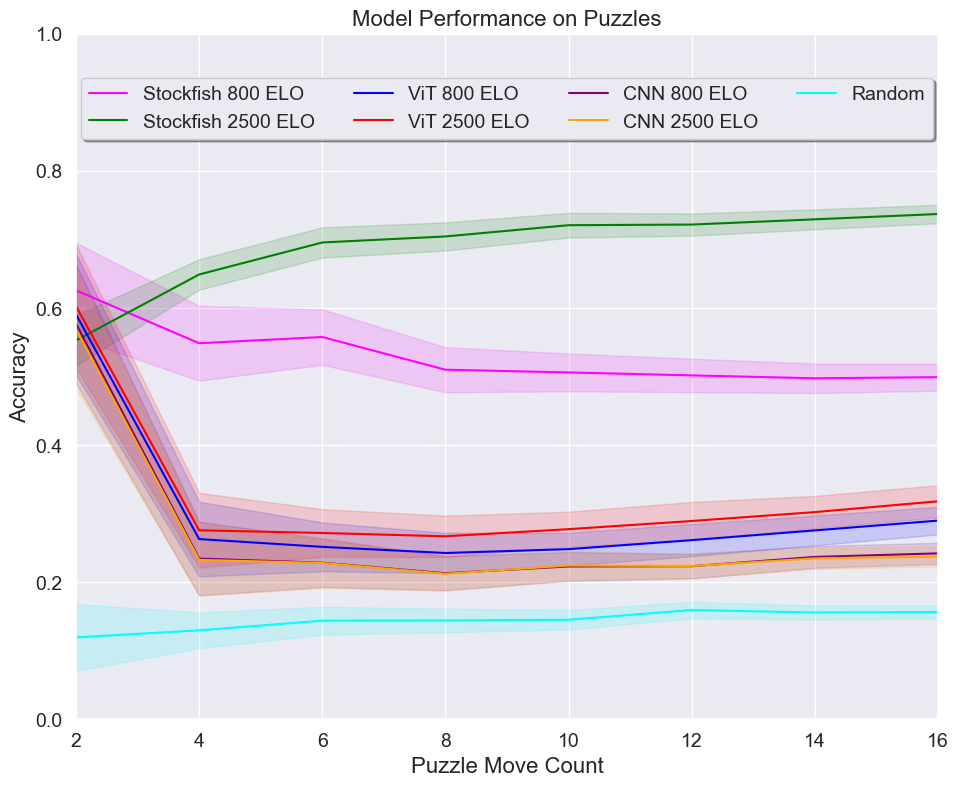

In [20]:


mean_arr = np.array(mean_arr)
std_arr = np.array(std_arr)

sns.set_style("darkgrid")
sns.set_theme()
plt.figure(figsize=(10, 8))
x = [i for i in range(2, 18, 2)]

colors = ['magenta', 'green', 'blue', 'red', 'purple', 'orange', 'cyan', 'gray', 'olive', 'cyan']

for i, model in enumerate(results):
    mean_arr = []
    std_arr = []

    for p in results[model]:
        mean_arr.append(p[0])
        std_arr.append(p[1]**2)

    mean_arr = np.array(mean_arr)
    std_arr = np.array(std_arr)

    plt.plot(x, mean_arr, label=model, color = colors[i])
    plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.15, color = colors[i])


FONT = 16

plt.title('Model Performance on Puzzles', fontsize=FONT)
plt.xlabel('Puzzle Move Count', fontsize=FONT)
plt.ylabel('Accuracy', fontsize=FONT)
plt.ylim(0, 1.0)
plt.xlim(2, 16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

legend_title = None # or "Method" or any other string if you desire a title
num_cols = 4
has_title = legend_title is not None
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95 + has_title * 0.05), fancybox=True, shadow=True, ncol=num_cols, title=legend_title, fontsize=14)

#Remove the padding of the figure
plt.tight_layout(pad=1)

plt.grid(True)
plt.savefig('puzzle_accuracy_3.pdf', dpi=300, format='pdf')
plt.show()



In [16]:
# for model in models:
#     for _ in range(5):
#         for puzzle in puzzles:
#             puzzle_df = pd.read_csv(f"Data/{puzzle}_moves.csv")
#             puzzle_df = puzzle_df.sample(frac=1).reset_index(drop=True)
#             correct, total, per_puzzle_avg = test_puzzle(model, puzzle_df, 50)
#             #CXorrect is total correct out of 50 puzzles for n moves each 

#             entry = [model.name, correct, per_puzzle_avg, total, puzzle + "_moves"]
#             results.loc[len(results)] = entry